MTA renovation optimizatio

0.: Import libraries

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
#import dateutil.parser
import seaborn as sns

from IPython.display import Image

from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

1.: Download a couple of MTA data sets and combine them into a data frame

In [2]:
# downloading a couple of MTA data sets and combining them

df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160917.txt')
dftemp = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160910.txt')
df = df.append(dftemp, ignore_index = True)
dftemp = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160903.txt')
df = df.append(dftemp, ignore_index = True)

# Sort by C/A, Unit, SCP, Station

df = df.sort_values(["C/A", "UNIT", "SCP", "STATION"])

In [3]:
df=df.rename(columns={'EXITS                                                               ': 'EXITS'})

2.: Turn this into a time series

In [4]:
# Add a column that combines date and time in the datetime format

df["DATETIME"] = df["DATE"] + " " + df["TIME"]
df["DATETIME"] = pd.to_datetime(df.DATETIME, infer_datetime_format=True)

In [5]:
# Sort by date and time and make the index a date time

df=df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATETIME"])
df.index = df["DATETIME"]

 3.: Select the station of interest

In [6]:
# Filter for station of interest and resample for 4 hour steps

df=df[df.STATION == '28 ST']

4.: Get sum of entries and exits

In [7]:
# Create a new column to get the daily count instead of the cumulative values and drop unused columns

df["DAILYENTRIES"]=df.ENTRIES.diff()
df["DAILYEXITS"]=df.EXITS.diff()

df['DAILYTRAFFIC'] = df['DAILYEXITS'] + df['DAILYENTRIES']
df=df[df.DATE > "09/02/2016"]

df=df.drop(["C/A",'UNIT','SCP','LINENAME','DIVISION','DATE','TIME','DESC','ENTRIES','EXITS','DATETIME','DAILYENTRIES','DAILYEXITS'], axis=1)

In [8]:
# Resample to 4 hour steps

df=df.resample('4H', how = np.sum)

/Users/Nils/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  app.launch_new_instance()


5.: Analyze traffic within the day

In [9]:
# Aggregate by the hour

df_dt = df.index.to_datetime()
df['hour']= df_dt.hour
df_hour=df.groupby(['hour'])['DAILYTRAFFIC'].mean()
df_hour=df_hour.reset_index()

/Users/Nils/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


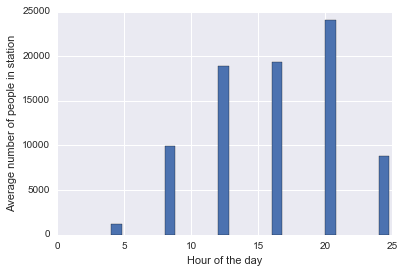

In [10]:
# adjust hour to the end of the time slot and plot ba chart

df_hour.hour.iloc[0]=24

plt.bar(df_hour.hour,df_hour.DAILYTRAFFIC)
plt.xlabel('Hour of the day')
plt.ylabel('Average number of people in station')

6.: Daily data

In [11]:
df['weekday']=df_dt.weekday

In [12]:
# Shift weekdays by one entry as midnight is maped towards the following day but has data of the previous 4 hours in it

df['weekdayadj']=df['weekday'].shift(periods=1)
df['weekdayadj'].iloc[0]=df['weekday'].iloc[0]-1

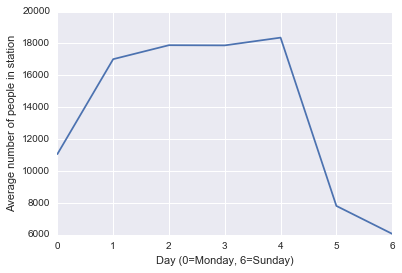

In [13]:
df_dayadj=df.groupby(['weekdayadj'])['DAILYTRAFFIC'].mean().reset_index()

plt.figure()

plt.plot(df_dayadj.weekdayadj,df_dayadj.DAILYTRAFFIC)
plt.xlabel('Day (0=Monday, 6=Sunday)')
plt.ylabel('Average number of people in station')

7.: Line graph hour over week

In [14]:
df_how=df

In [15]:
def change_midnight(x):
    if x == 0:
        return 24
    return x

df_how['hour'] = df_how['hour'].map(change_midnight)

In [16]:
df_how['datetime'] = df_how['weekdayadj']*24+df_how['hour']

In [17]:
df_how=df_how.groupby(['datetime'])['DAILYTRAFFIC'].mean().reset_index()

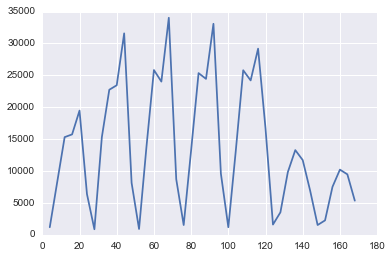

In [18]:
plt.plot(df_how['datetime'],df_how['DAILYTRAFFIC'])